In [1]:
from json import JSONDecodeError
import json
from src.utils.model_utils import *
from src.utils.output_formatter import *
from nervaluate import Evaluator

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tokenizer = get_base_tokenizer()

In [3]:
sentences = []
true_responses = []

In [4]:
with open(load_config().get("test_dataset_path"), 'r') as file:
    testing_data = json.load(file)

for item in testing_data:
    if 'user' not in item or 'assistant' not in item:
        print("problem with item:", item)
    sentences.append(item['user'])
    true_responses.append(transform_to_prodigy(item['user'], item['assistant']))

## Generating Results on Testing Dataset

In [8]:
invalid_indices = set()

### Responses From Base Model

In [12]:
base_model = get_base_model()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
generated_responses_base = []
for sentence in sentences:
    generated_responses_base.append(generate_response(sentence, base_model, tokenizer))

So we can re-use the generated responses after restarting the notebook:

In [6]:
store_results(generated_responses_base, "../evaluation_output/base_model.txt", do_backup=True)

In [38]:
generated_responses_base = load_results("../evaluation_output/base_model.txt")

In [39]:
invalid_json_format = 0
invalid_key = 0
pred_responses_base = []
for i in range(len(generated_responses_base)):
    predicted = []
    try:
        predicted = transform_to_prodigy(sentences[i], generated_responses_base[i])
    except (JSONDecodeError, KeyError) as err:
        if isinstance(err, KeyError):
            invalid_key += 1
        else:
            invalid_json_format += 1
        invalid_indices.add(i)
    pred_responses_base.append(predicted)

print(f"Invalid format: {invalid_json_format + invalid_key} out of {len(generated_responses_base)} times ({invalid_json_format} JSONDecodeError, {invalid_key} KeyError)")

Invalid format: 665 out of 2422 times (610 JSONDecodeError, 55 KeyError)


### Responses From Fine-tuned Model

In [ ]:
finetuned_model = get_finetuned_model("/checkpoint-1460")

In [ ]:
generated_responses_finetuned = []
for sentence in sentences:
    generated_responses_finetuned.append(generate_response(sentence, finetuned_model, tokenizer))

In [14]:
store_results(generated_responses_finetuned, '../evaluation_output/finetuned_mixed_train.txt', do_backup=True)

In [40]:
generated_responses_finetuned = load_results('../evaluation_output/finetuned_mixed_train.txt')

In [41]:
invalid_json_format = 0
invalid_key = 0
pred_responses_finetuned = []
for i in range(len(generated_responses_finetuned)):
    predicted = []
    try:
        predicted = transform_to_prodigy(sentences[i], generated_responses_finetuned[i])
    except (JSONDecodeError, KeyError) as err:
        if isinstance(err, KeyError):
            invalid_key += 1
        else:
            invalid_json_format += 1
        invalid_indices.add(i)
    pred_responses_finetuned.append(predicted)
print(f"Invalid format: {invalid_json_format + invalid_key} out of {len(generated_responses_finetuned)} times ({invalid_json_format} JSONDecodeError, {invalid_key} KeyError)")

Invalid format: 114 out of 2422 times (76 JSONDecodeError, 38 KeyError)


### Responses From Base NuExtract Model

In [33]:
nuextract_config = load_config("nuextract_config.json")

In [23]:
base_nuextract = get_base_model(nuextract_config.get("model"))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
generated_responses_base_nuextract = []
i = 0
for sentence in sentences:
    if not i%100:
        store_results(generated_responses_base_nuextract, "../evaluation_output/base_nuextract.txt")
    i+=1
    generated_responses_base_nuextract.append(generate_response(sentence, base_nuextract, tokenizer, nuextract_config.get("system_prompt")))

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
You are not running the flash-attention implementation, expect numerical differences.


In [6]:
generated_responses_base_nuextract

[' {"Chemicals": ["famotidine"], "Diseases": ["delirium"]}',
 ' {"Chemicals": ["famotidine"], "Diseases": ["delirium"]}',
 ' {"Chemicals": ["famotidine", "Indomethacin"], "Diseases": ["hypotension"]}',
 ' {"Chemicals": ["indomethacin"], "Diseases": ["hypertension"]}',
 ' {"Chemicals": ["tacrolimus", "prednisolone"], "Diseases": ["late-onset scleroderma renal crisis"]}',
 ' {"Chemicals": ["corticosteroids"], "Diseases": ["Scleroderma renal crisis", "systemic sclerosis"]}',
 ' {"Chemicals": ["cyclosporine", "tacrolimus"], "Diseases": ["thrombotic microangiopathy", "Systemic Scleroderma (SSc)", "Systemic Rheumatic Candidiasis (SRC)"]}',
 ' {"Chemicals": ["tacrolimus", "methamphetamine"], "Diseases": ["psychosis", "SSc"]}',
 ' {"Chemicals": ["methamphetamine"], "Diseases": ["lifetime methamphetamine-induced psychosis", "current methamphetamine-induced psychosis", "psychiatric co-morbidity"]}',
 ' {"Chemicals": ["methamphetamine"], "Diseases": ["methamphetamine-induced psychosis", "Axis I p

In [25]:
store_results(generated_responses_base_nuextract, "../evaluation_output/base_nuextract.txt", do_backup=True)

In [5]:
generated_responses_base_nuextract = load_results("../evaluation_output/base_nuextract.txt")

In [26]:
invalid_json_format = 0
invalid_key = 0
pred_responses_base_nuextract = []
for i in range(len(generated_responses_base_nuextract)):
    predicted = []
    try:
        default_format_sentence = numind_to_default(generated_responses_base_nuextract[i])
        predicted = transform_to_prodigy(sentences[i], json.dumps(default_format_sentence))
    except (JSONDecodeError, KeyError) as err:
        if isinstance(err, KeyError):
            invalid_key += 1
        else:
            invalid_json_format += 1
        invalid_indices.add(i)
    pred_responses_base_nuextract.append(predicted)
print(f"Invalid format: {invalid_json_format + invalid_key} out of {len(generated_responses_base_nuextract)} times ({invalid_json_format} JSONDecodeError, {invalid_key} KeyError)")

Invalid format: 521 out of 2422 times (521 JSONDecodeError, 0 KeyError)


### Responses From OpenAI Model

In [8]:
generated_responses_openai = []
for sentence in sentences:
    generated_responses_openai.append(generate_openai(sentence), model_name="gpt-4o-mini", provider="litellm")
    # claude-3

In [7]:
store_results(generated_responses_openai, "../evaluation_output/openai.txt", do_backup=True)

In [42]:
generated_responses_openai = load_results("../evaluation_output/openai.txt")

In [43]:
invalid_json_format = 0
invalid_key = 0
pred_responses_openai = []
for i in range(len(generated_responses_openai)):
    predicted = []
    try:
        predicted = transform_to_prodigy(sentences[i], generated_responses_openai[i])
    except (JSONDecodeError, KeyError) as err:
        if isinstance(err, KeyError):
            invalid_key += 1
        else:
            invalid_json_format += 1
        invalid_indices.add(i)
    pred_responses_openai.append(predicted)

print(f"Invalid format: {invalid_json_format + invalid_key} out of {len(generated_responses_openai)} times ({invalid_json_format} JSONDecodeError, {invalid_key} KeyError)")

Invalid format: 0 out of 2422 times (0 JSONDecodeError, 0 KeyError)


### Responses from Deepseek V3

In [5]:
generated_responses_deepseek = []
at = 0
for sentence in sentences:
    at += 1
    generated_responses_deepseek.append(generate_openai(sentence, model_name="deepseek-chat", provider="deepseek"))
    if at % 100 == 0:
        with open(f'evaluation_output/openai{at}.txt', 'w') as file:
            file.write("\n$SEP$\n".join(generated_responses_deepseek))

In [6]:
store_results(generated_responses_deepseek, "../evaluation_output/deepseek.txt", do_backup=True)

In [44]:
generated_responses_deepseek = load_results("../evaluation_output/deepseek.txt")

In [45]:
invalid_json_format = 0
invalid_key = 0
pred_responses_deepseek = []
for i in range(len(generated_responses_deepseek)):
    predicted = []
    try:
        predicted = transform_to_prodigy(sentences[i], generated_responses_deepseek[i])
    except (JSONDecodeError, KeyError) as err:
        if isinstance(err, KeyError):
            invalid_key += 1
        else:
            invalid_json_format += 1
        invalid_indices.add(i)
    pred_responses_deepseek.append(predicted)

print(f"Invalid format: {invalid_json_format + invalid_key} out of {len(generated_responses_deepseek)} times ({invalid_json_format} JSONDecodeError, {invalid_key} KeyError)")

Invalid format: 4 out of 2422 times (4 JSONDecodeError, 0 KeyError)


### Separate variables for valid responses
Removing faulty data to better understand generating logic

In [46]:
cleaned_base_responses, cleaned_finetuned_responses, cleaned_nuextract_responses, cleaned_openai_responses, cleaned_deepseek_responses, cleaned_true_responses = [], [], [], [], [], []

for index in range(len(true_responses)):
    if index in invalid_indices:
        continue
    cleaned_base_responses.append(pred_responses_base[index])
    cleaned_finetuned_responses.append(pred_responses_finetuned[index])
    cleaned_nuextract_responses.append(pred_responses_base_nuextract[index])
    cleaned_openai_responses.append(pred_responses_openai[index])
    cleaned_deepseek_responses.append(pred_responses_deepseek[index])
    cleaned_true_responses.append(true_responses[index])

### Manual Evaluation

From previous cells, we can calculate how often the model generates an invalid response

In [47]:
print(f"Phi-3 Mini:           \t{round(665/2422*100,3)}%\t(665 out of 2422)")
print(f"Fine-tuned Phi-3 Mini:\t{round(114/2422*100,3)}%\t(114 out of 2422)")
print(f"NuExtract 1.5:        \t{round(521/2422*100,3)}%\t(521 out of 2422)")
print(f"GPT-4o mini:          \t0%\t\t(0 out of 2422)")
print(f"Deepseek V3:          \t{round(4/2422*100,3)}%\t(4 out of 2422)")

Phi-3 Mini:           	27.457%	(665 out of 2422)
Fine-tuned Phi-3 Mini:	4.707%	(114 out of 2422)
NuExtract 1.5:        	21.511%	(521 out of 2422)
GPT-4o mini:          	0%		(0 out of 2422)
Deepseek V3:          	0.165%	(4 out of 2422)


We can also draw conclusions from how many entities each model predicted. We will not consider the inputs that received an invalid response from either of the models (similar to removing rows with null values)

In [48]:
print(f"Phi-3 Mini:           \t{sum(len(x) for x in cleaned_base_responses)}")
print(f"Fine-tuned Phi-3 Mini:\t{sum(len(x) for x in cleaned_finetuned_responses)}")
print(f"NuExtract 1.5:        \t{sum(len(x) for x in cleaned_nuextract_responses)}")
print(f"GPT-4o mini:          \t{sum(len(x) for x in cleaned_openai_responses)}")
print(f"Deepseek V3:          \t{sum(len(x) for x in cleaned_deepseek_responses)}")
print(f"True amount:          \t{sum(len(x) for x in cleaned_true_responses)}")

Phi-3 Mini:           	6315
Fine-tuned Phi-3 Mini:	4985
NuExtract 1.5:        	4192
GPT-4o mini:          	4639
Deepseek V3:          	3508
True amount:          	5712


We can see that the base Phi-3 Mini model greatly overestimated what was considered an entity while the larger models on the contrary underestimated it.

### NERvaluate evaluation

#### Evaluating all responses

In [49]:
evaluator = Evaluator(true_responses, pred_responses_base, tags=['Disease', 'Chemical'])
base_results = evaluator.evaluate()[0]
evaluator = Evaluator(true_responses, pred_responses_finetuned, tags=['Disease', 'Chemical'])
finetuned_results = evaluator.evaluate()[0]
evaluator = Evaluator(true_responses, pred_responses_base_nuextract, tags=['Disease', 'Chemical'])
nuextract_results = evaluator.evaluate()[0]
evaluator = Evaluator(true_responses, pred_responses_openai, tags=['Disease', 'Chemical'])
openai_results = evaluator.evaluate()[0]
evaluator = Evaluator(true_responses, pred_responses_deepseek, tags=['Disease', 'Chemical'])
deepseek_results = evaluator.evaluate()[0]

In [51]:
# Prepare data in the desired format
data = []

# Iterate over each model and each metric type within the model
for model_name, model_data in zip(
    ["Base", "Fine-tuned", "NuExtract", "DeepSeek", "OpenAI"],
    [base_results, finetuned_results, nuextract_results, deepseek_results, openai_results]
):
    for metric, values in model_data.items():
        row = [model_name, metric] + list(values.values())
        data.append(row)

columns = ["Model", "Schema"] + list(base_results["ent_type"].keys())

df = pd.DataFrame(data, columns=columns)
# improve readability
df["Model"] = df["Model"].mask(df["Model"].duplicated(), "")
df.set_index(["Model", "Schema"], inplace=True)
df[["precision", "recall", "f1"]] = df[["precision", "recall", "f1"]].round(3)
# misleading for our purpose
df.drop(columns=['possible', 'actual'], inplace=True)
df


correct  incorrect  partial  missed  spurious  precision  \
Model      Schema                                                               
Base       ent_type     5285        209        0    4337      2692      0.646   
           partial      4492          0     1002    4337      2692      0.610   
           strict       4415       1079        0    4337      2692      0.539   
           exact        4492       1002        0    4337      2692      0.549   
Fine-tuned ent_type     6142        315        0    3358      2396      0.694   
           partial      5117          0     1340    3358      2396      0.654   
           strict       5015       1442        0    3358      2396      0.566   
           exact        5117       1340        0    3358      2396      0.578   
NuExtract  ent_type     4948        102        0    4755       897      0.832   
           partial      4115          0      935    4755       897      0.771   
           strict       4097        953        0    4755       897      0.689   
           exact        4115        935        0    4755       897      0.692   
DeepSeek   ent_type     5382         46        0    4381       256      0.947   
           partial      4972          0      456    4381       256      0.915   
           strict       4968        460        0    4381       256      0.874   
           exact        4972        456        0    4381       256      0.875   
OpenAI     ent_type     6825         72        0    2917       913      0.874   
           partial      6196          0      701    2917       913      0.838   
           strict       6178        719        0    2917       913      0.791   
           exact        6196        701        0    2917       913      0.793   

                     recall     f1  
Model      Schema                   
Base       ent_type   0.538  0.587  
           partial    0.508  0.554  
           strict     0.449  0.490  
           exact      0.457  0.499  
Fine-tuned ent_type   0.626  0.658  
           partial    0.590  0.620  
           strict     0.511  0.537  
           exact      0.521  0.548  
NuExtract  ent_type   0.505  0.628  
           partial    0.467  0.582  
           strict     0.418  0.520  
           exact      0.420  0.522  
DeepSeek   ent_type   0.549  0.695  
           partial    0.530  0.671  
           strict     0.506  0.641  
           exact      0.507  0.642  
OpenAI     ent_type   0.695  0.775  
           partial    0.667  0.743  
           strict     0.630  0.701  
           exact      0.631  0.703

In [60]:
def graph_for_metric(metric_name: str, _base_results=base_results, _finetuned_results=finetuned_results, _nuextract_results=nuextract_results,
                     _deepseek_results=deepseek_results, _openai_results=openai_results, ax=None):
    data = {
        "Metric": list(_base_results.keys()),
        "Base Model": [_base_results[metric][metric_name] for metric in _base_results.keys()],
        "Fine-Tuned Model": [_finetuned_results[metric][metric_name] for metric in _finetuned_results.keys()],
        "NuExtract Model": [_nuextract_results[metric][metric_name] for metric in _nuextract_results.keys()],
        "Deepseek V3": [_deepseek_results[metric][metric_name] for metric in _deepseek_results.keys()],
        "GPT-4o mini": [_openai_results[metric][metric_name] for metric in _openai_results.keys()],
    }

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(df["Metric"]))  # the label locations
    width = 0.15  # the width of the bars

    # Plot bars for each model
    ax.bar(x - width, df["Base Model"], width, label="Base Phi-3 Mini")
    ax.bar(x, df["Fine-Tuned Model"], width, label="Fine-Tuned Phi-3 Mini")
    ax.bar(x + width, df["NuExtract Model"], width, label="Base NuExtract 1.5")
    ax.bar(x + 2*width, df["Deepseek V3"], width, label="Deepseek V3")
    ax.bar(x + 3*width, df["GPT-4o mini"], width, label="GPT-4o mini")

    # Labels and title
    ax.set_xlabel("Evaluation Schema")
    ax.set_ylabel(f"{metric_name.capitalize()} Score")
    ax.set_title(f"Comparison of {metric_name.capitalize()} Scores Across Models")
    ax.set_xticks(x)
    ax.set_xticklabels(df["Metric"])
    ax.legend()

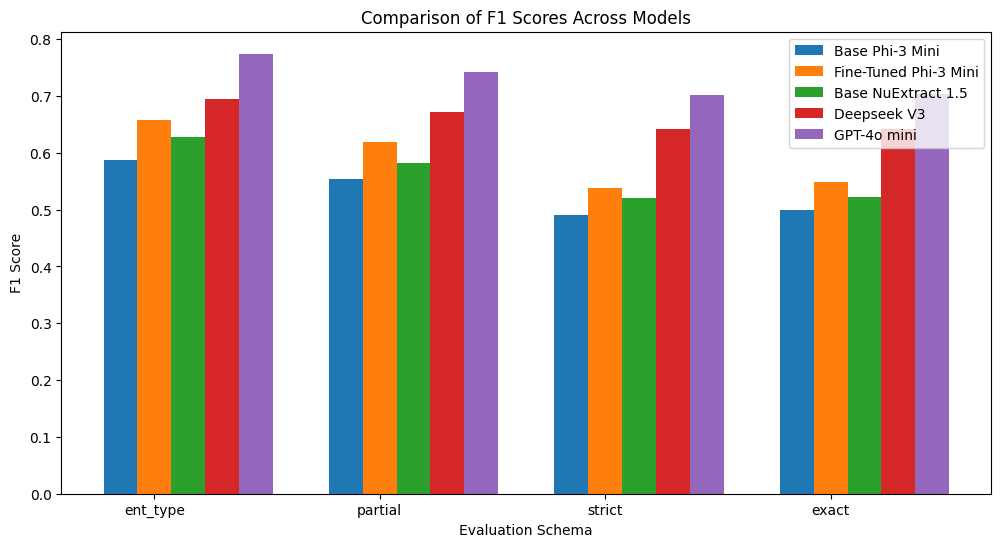

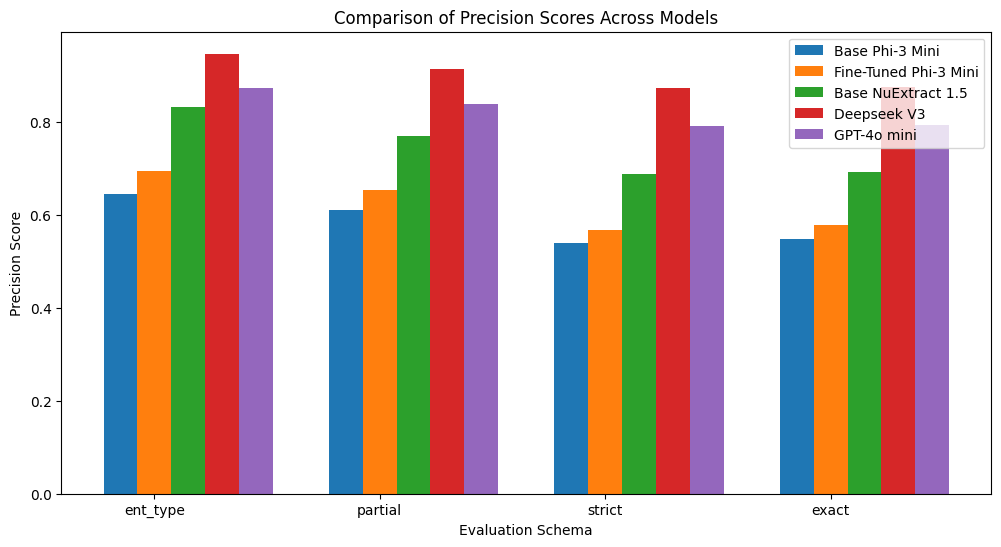

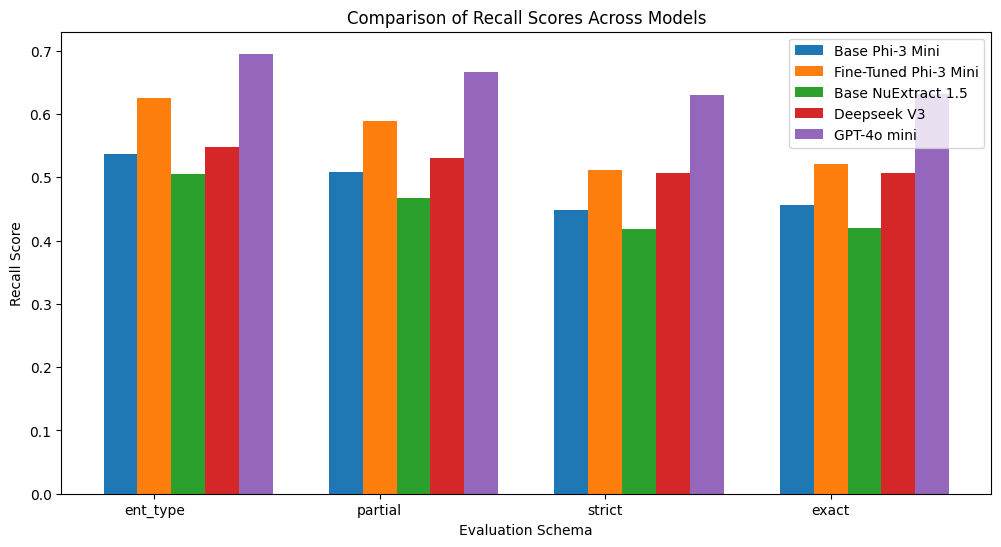

In [61]:
graph_for_metric("f1")
graph_for_metric("precision")
graph_for_metric("recall")

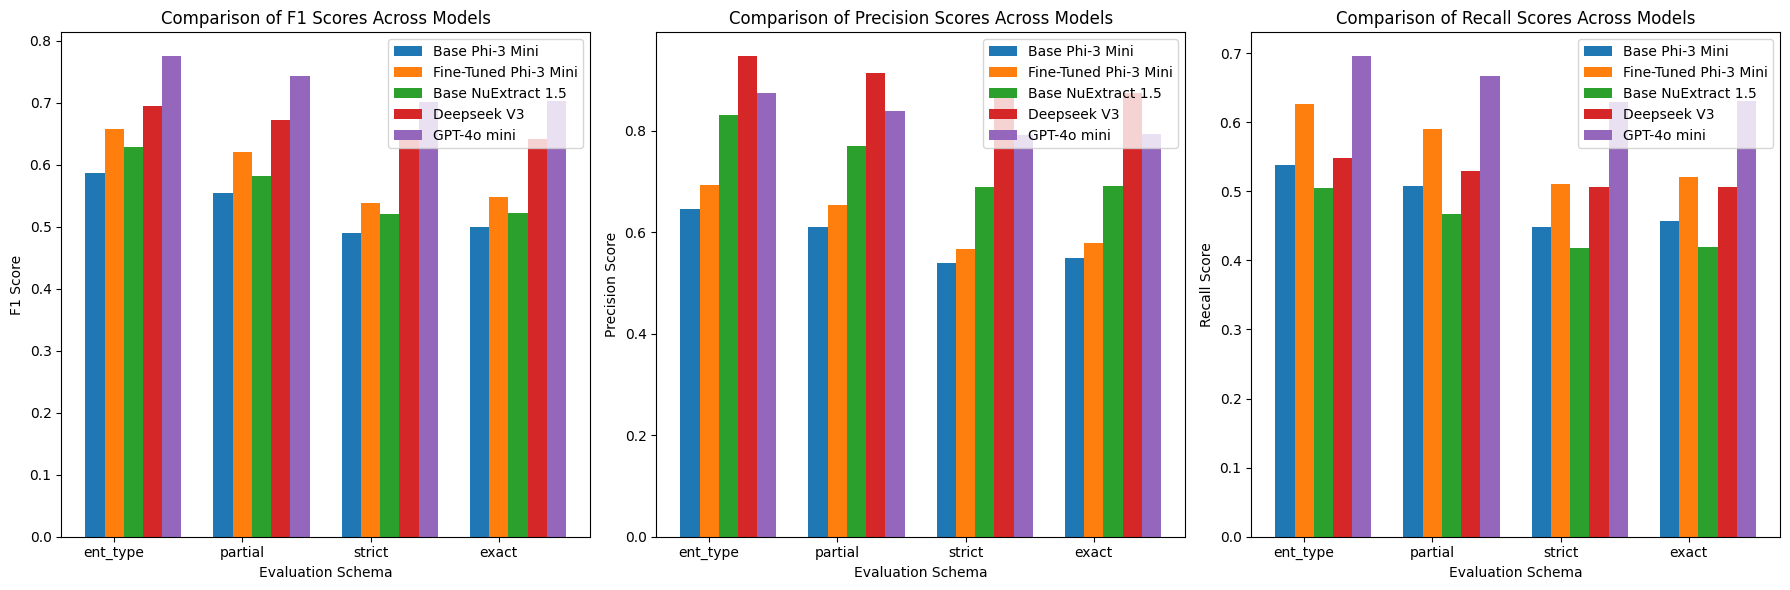

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, metric in enumerate(["f1", "precision", "recall"]):
    graph_for_metric(metric, ax=axes[i])
plt.tight_layout()
plt.show()


#### Evaluating only valid responses

In [27]:
evaluator = Evaluator(cleaned_true_responses, cleaned_base_responses, tags=['Disease', 'Chemical'])
cleaned_base_results = evaluator.evaluate()[0]
evaluator = Evaluator(cleaned_true_responses, cleaned_finetuned_responses, tags=['Disease', 'Chemical'])
cleaned_finetuned_results = evaluator.evaluate()[0]
evaluator = Evaluator(cleaned_true_responses, cleaned_openai_responses, tags=['Disease', 'Chemical'])
cleaned_openai_results = evaluator.evaluate()[0]
evaluator = Evaluator(cleaned_true_responses, cleaned_deepseek_responses, tags=['Disease', 'Chemical'])
cleaned_deepseek_results = evaluator.evaluate()[0]

In [28]:
# Prepare data in the desired format
data = []

# Iterate over each model and each metric type within the model
for model_name, model_data in zip(
    ["Base", "Fine-tuned", "DeepSeek", "OpenAI"],
    [cleaned_base_results, cleaned_finetuned_results, cleaned_deepseek_results, cleaned_openai_results]
):
    for metric, values in model_data.items():
        row = [model_name, metric] + list(values.values())
        data.append(row)

columns = ["Model", "Schema"] + list(base_results["ent_type"].keys())

df = pd.DataFrame(data, columns=columns)
# improve readability
df.set_index(["Model", "Schema"], inplace=True)
df[["precision", "recall", "f1"]] = df[["precision", "recall", "f1"]].round(3)
# misleading for our purpose
df.drop(columns=['possible', 'actual'], inplace=True)
df

correct  incorrect  partial  missed  spurious  precision  \
Model      Schema                                                               
Base       ent_type     5140        201        0    1646      2607      0.647   
           partial      4376          0      965    1646      2607      0.611   
           strict       4307       1034        0    1646      2607      0.542   
           exact        4376        965        0    1646      2607      0.551   
Fine-tuned ent_type     4614        226        0    2129      1455      0.733   
           partial      3863          0      977    2129      1455      0.691   
           strict       3787       1053        0    2129      1455      0.602   
           exact        3863        977        0    2129      1455      0.614   
DeepSeek   ent_type     3976         36        0    2953       195      0.945   
           partial      3688          0      324    2953       195      0.915   
           strict       3684        328        0    2953       195      0.876   
           exact        3688        324        0    2953       195      0.877   
OpenAI     ent_type     4971         44        0    1952       628      0.881   
           partial      4528          0      487    1952       628      0.846   
           strict       4517        498        0    1952       628      0.800   
           exact        4528        487        0    1952       628      0.802   

                     recall     f1  
Model      Schema                   
Base       ent_type   0.736  0.688  
           partial    0.695  0.651  
           strict     0.616  0.577  
           exact      0.626  0.586  
Fine-tuned ent_type   0.662  0.696  
           partial    0.624  0.656  
           strict     0.543  0.571  
           exact      0.554  0.582  
DeepSeek   ent_type   0.571  0.712  
           partial    0.553  0.689  
           strict     0.529  0.660  
           exact      0.530  0.660  
OpenAI     ent_type   0.714  0.788  
           partial    0.685  0.757  
           strict     0.648  0.716  
           exact      0.650  0.718

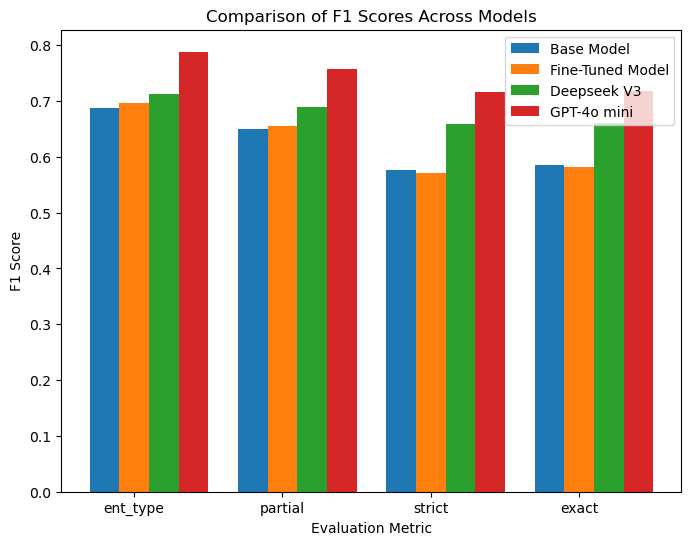

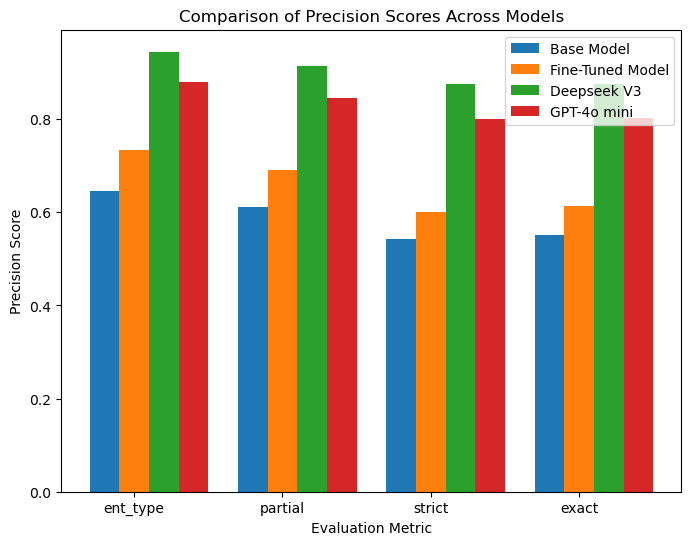

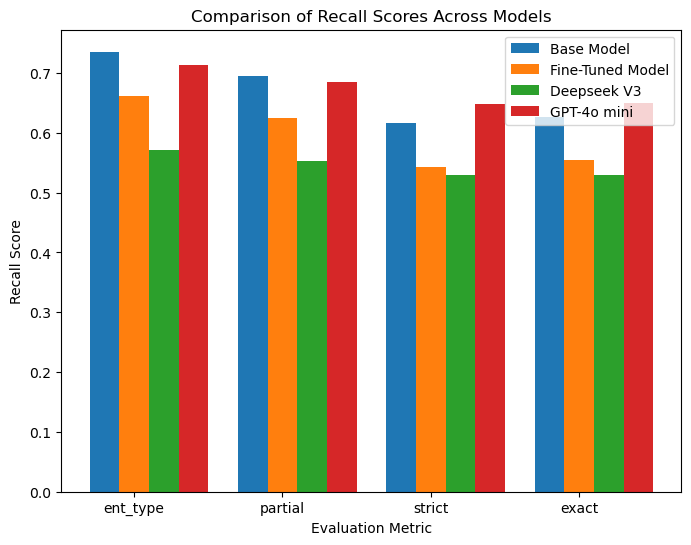

In [31]:
graph_for_metric("f1", cleaned_base_results, cleaned_finetuned_results, cleaned_deepseek_results, cleaned_openai_results)
graph_for_metric("precision", cleaned_base_results, cleaned_finetuned_results, cleaned_deepseek_results, cleaned_openai_results)
graph_for_metric("recall", cleaned_base_results, cleaned_finetuned_results, cleaned_deepseek_results, cleaned_openai_results)

#### Storing the results

In [19]:
with open("results/base_results.json", "w") as file:
    json.dump(base_results, file)
with open("results/openai_results.json", "w") as file:
    json.dump(openai_results, file)
with open("results/finetuned_results.json", "w") as file:
    json.dump(finetuned_results, file)

### InterpretEval evaluation

In [ ]:
interpret_eval_base = prodigy_to_interpreteval(pred_responses_base)
interpret_eval_openai = prodigy_to_interpreteval(pred_responses_openai)
interpret_eval_finetuned = prodigy_to_interpreteval(pred_responses_finetuned)